In [1]:
import os
import itertools
from collections import Counter
import json
import statistics

from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, Ridge, Lasso


import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import mixup, write_pickled_object, cohen_d, aggregate_ranks
from utils import get_stats as get_stats_best
from utils import RNAFeatureSelector, MeanCenterer

/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 42

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
res = pd.read_csv(os.path.join(data_path, 'interim', 
                               'pipeline_model_selection_transcriptomics_individual.csv'), index_col = 0)
model_types = ['Ridge', 'ElasticNet', 'Lasso', 'PLS', 'SVR_linear',
               'SVR_poly', 'SVR_rbf', 'KNN', 'RFR']
res.model_type = pd.Categorical(res.model_type, categories = model_types, ordered = True)

First, let's get a rank-ordering across our two test metrics, MSE and Pearson correlation. For each model, we first aggregate by median value across folds. Then, we calculate the rank of the model (lower rank = better performance) for each test metric. Finally, we aggregate across test metrics using the stringent maximum rank per model -- what is the worse the model performed.

In [4]:
rank_order = aggregate_ranks(
    opt_res=res.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'median'
)
model_order = rank_order['model_type'].tolist()
rank_order

,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,SVR_rbf,1.778819,0.533403,1.0,1.0,1.0,1.0
1,SVR_poly,1.857148,0.510510,2.0,2.0,2.0,2.0
2,Lasso,1.901574,0.476951,4.0,4.0,4.0,3.5
3,SVR_linear,1.898212,0.476075,3.0,5.0,4.0,3.5
4,Ridge,1.998191,0.499628,7.0,3.0,5.0,5.0
5,ElasticNet,1.925323,0.464943,5.0,7.0,6.0,6.0
6,PLS,2.014831,0.468124,8.0,6.0,7.0,7.5
7,RFR,1.974721,0.429948,6.0,8.0,7.0,7.5
8,KNN,2.091510,0.386203,9.0,9.0,9.0,9.0


We see that some models are tied:
- Lasso and SVR Linear
- PLS and RFR

We use the standard deviation as a tie breaker:

In [5]:
rank_order_std = aggregate_ranks(
    opt_res=res.groupby('model_type', observed = True)[['test_mse', 'test_corr']].std().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'lower'
    },
    method = 'median'
)
rank_order_std

,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,PLS,0.371152,0.089316,2.0,1.0,1.5,1.0
1,Ridge,0.376375,0.115720,3.0,2.0,2.5,2.0
2,SVR_rbf,0.356007,0.120675,1.0,5.0,3.0,3.0
3,SVR_linear,0.388883,0.118636,7.0,3.0,5.0,4.0
4,KNN,0.376411,0.138576,4.0,8.0,6.0,6.0
5,ElasticNet,0.376669,0.128302,5.0,7.0,6.0,6.0
6,RFR,0.386236,0.128199,6.0,6.0,6.0,6.0
7,SVR_poly,0.401471,0.119122,9.0,4.0,6.5,8.0
8,Lasso,0.392732,0.139905,8.0,9.0,8.5,9.0


In this case, Lasso has a worse standard deviation than SVR linear, so we will rank it lower. 

In [11]:
model_order = [
    'SVR_rbf',
    'SVR_poly',
    'SVR_linear',
    'Lasso',
    'Ridge',
    'ElasticNet',
    'PLS',
    'RFR',
    'KNN'
]
print('The model rank order is: ')
print(*model_order, sep = ', ')

The model rank order is: 
SVR_rbf, SVR_poly, SVR_linear, Lasso, Ridge, ElasticNet, PLS, RFR, KNN


Let's take a look at the results from the model selection:

Let's compare each models performance with identified best hyperparameters for a specific fold:

In [12]:
import copy
res_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = itertools.combinations((res.model_type.unique()), 2)

for mc in copy.deepcopy(mod_combs):
    a = res[res.model_type == mc[0]]
    b = res[res.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_stats.loc[res_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_stats.pval_mse.values, method='fdr_bh')
res_stats['fdr_corr'] = fdr_corr
res_stats['fdr_mse'] = fdr_mse
res_stats.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_comparison_stats.csv'))
res_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, PLS)",0.850107,0.017247,0.472676,-0.249782,0.963235,0.897374
1,"(SVR_linear, Ridge)",0.791337,-0.090317,0.73373,-0.119422,0.963235,0.910837
2,"(SVR_linear, Lasso)",0.909722,-0.025701,1.0,0.036421,0.963235,1.0
3,"(SVR_linear, ElasticNet)",0.96985,0.018425,0.909722,-0.005374,0.99756,1.0
4,"(SVR_linear, SVR_poly)",0.677585,-0.243557,0.57075,0.196518,0.963235,0.897374
5,"(SVR_linear, SVR_rbf)",0.427355,-0.29173,0.384673,0.291655,0.963235,0.897374
6,"(SVR_linear, RFR)",0.57075,0.233428,0.384673,-0.247494,0.963235,0.897374
7,"(SVR_linear, KNN)",0.307489,0.445795,0.57075,-0.302623,0.963235,0.897374
8,"(PLS, Ridge)",0.57075,-0.119916,0.73373,0.131756,0.963235,0.910837
9,"(PLS, Lasso)",0.791337,-0.043834,0.520523,0.285744,0.963235,0.897374


In [13]:
res_stats[['fdr_corr', 'fdr_mse']].min().min()

0.897373762390249

In [14]:
res_stats[['fdr_corr', 'fdr_mse']].min().min()

0.897373762390249

In [15]:
res_stats[res_stats.fdr_corr <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


In [16]:
res_stats[res_stats.fdr_mse <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


There are no significant differences in model performance by either Pearson correlation or MSE.

To reduce the multiple testing burden, let's also subset to our top 3 models by rank, and see whether there are any significant differences in this case.

In [17]:
res_sub = res[res.model_type.isin(model_order[:4])].copy()

res_sub_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs_sub = itertools.combinations((res_sub.model_type.unique()), 2)

for mc in mod_combs_sub:
    a = res_sub[res_sub.model_type == mc[0]]
    b = res_sub[res_sub.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_sub_stats.loc[res_sub_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_sub_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_sub_stats.pval_mse.values, method='fdr_bh')
res_sub_stats['fdr_corr'] = fdr_corr
res_sub_stats['fdr_mse'] = fdr_mse
# res_sub_stats.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_comparison_stats.csv'))
res_sub_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, Lasso)",0.909722,-0.025701,1.0,0.036421,0.909722,1.0
1,"(SVR_linear, SVR_poly)",0.677585,-0.243557,0.57075,0.196518,0.909722,0.949604
2,"(SVR_linear, SVR_rbf)",0.427355,-0.29173,0.384673,0.291655,0.909722,0.949604
3,"(Lasso, SVR_poly)",0.909722,-0.197185,0.73373,0.159736,0.909722,0.949604
4,"(Lasso, SVR_rbf)",0.677585,-0.241685,0.472676,0.252114,0.909722,0.949604
5,"(SVR_poly, SVR_rbf)",0.850107,-0.049663,0.791337,0.081867,0.909722,0.949604


We can see that even here, none of our models have significant differences in performance. 

/tmp/ipykernel_2507153/72843879.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = axA[i],
/tmp/ipykernel_2507153/72843879.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axA[i].set_xticklabels(xlabels,
/tmp/ipykernel_2507153/72843879.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = axA[i],
/tmp/ipykernel_2507153/72843879.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axA[i].set_x

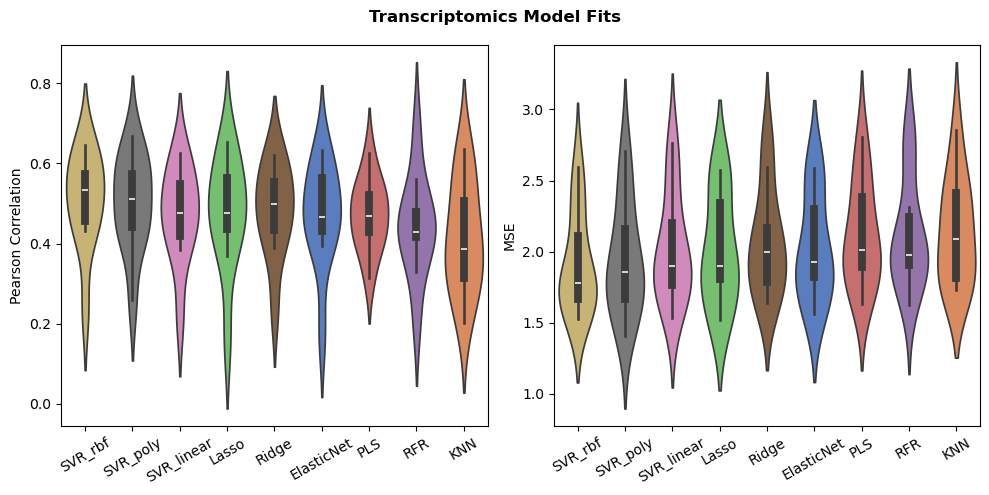

In [17]:
figA, axA = plt.subplots(ncols = 2, figsize = (10,5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))
# order_map = dict(zip(metric_types, [corr_order, mse_order]))
order_map = dict(zip(metric_types, [model_order, model_order]))

palette = dict(zip(sorted(res.model_type.unique()), sns.color_palette("muted")))

for i, metric_type in enumerate(metric_types):
    # sort by mean of metric
    res.model_type = pd.Categorical(res.model_type, categories = order_map[metric_type], 
                               ordered = True)
    
    
    sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = axA[i], 
                  palette = palette)#,
#                    fill = False, inner = None)
    
#     sns.boxplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                 width=0.1, 
#                 color="black", showcaps=False, boxprops={'facecolor':'none'}, 
#                 whiskerprops={'linewidth':0.5}, ax = axA[i])
#     sns.stripplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                   alpha=0.5, jitter=True, dodge=True, ax = axA[i], color = 'black')
    
    axA[i].set_xlabel('')
    axA[i].set_ylabel(mmap[metric_type])
    
    xlabels = [x._text for x in axA[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, axA[i].get_xticks()))
    y, h = axA[i].get_ylim()[1], 0.05
    
    axA[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr_' + metric_type].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d_' + metric_type].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
            y_pos = y+(sig_counter*0.15)
            axA[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=1.01
            axA[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1

#     axA[i].grid(axis='y', linestyle='--', alpha=0.7)
    
figA.suptitle('Transcriptomics Model Fits',
    fontweight='bold',  # Makes the text bold
)
figA.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'all_models_transcriptomics.png'), 
            dpi=300, 
            bbox_inches="tight")  


For each metric (panels), violin plots are ordered by the best performing rank across folds. Each fold has the best model selected using optuna hyperparameter tuning. We observe the following: 
- there are no significant differences in any of the model performance for both correlation and MSE
- relative model performance is consistent between correlation and MSE, with SVMs performing best
- the worse performing models tend to have higher variance across folds

Thus, for this dataset, non-linear models do not outperform linear models.

# Consensus model

In [18]:
def p_max(x):
    counts = Counter(x)
    most_common_count = counts.most_common(1)[0][1]
    return most_common_count / len(x)

In [19]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)['mean'].values.ravel()
X.shape


(481, 16371)

Given that SVMs perform best and there are no significant differences, we proceed with the linear SVM as it is more interpretable. We generate a consensus model based on the hyperparameters selected across folds. We assess how that consensus model performs across a 10-fold split that is different than the one run during Notebook 02.

We see that consistently, all features were selected. For the C and epsilon hyperparameters, we take the mean value across folds.

Let's also see how the other SVMs perform, since they were highly ranked:

In [20]:
model_type = 'SVR_linear'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
for k, bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1][:-1])
    
    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)
    
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}'.format(k, n_features, C, epsilon))

    
n_features_best = statistics.mode(n_features_best) if p_max(n_features_best)>=0.5 else int(round(np.mean(n_features_best)))
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)


print('The connsensus model has features: {}, C: {:4f}, epsilon: {:.4f}'.format(n_features_best, C_best, epsilon_best))


best_steps = [
    ("feature_reduction", RNAFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=C_best,
    epsilon=epsilon_best
)))
best_pipeline = Pipeline(best_steps)
write_pickled_object(best_pipeline, 
                    os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline


SVR_linear
Fold: 0, features: 16371, C: 0.005219, epsilon: 0.9146
Fold: 1, features: 16371, C: 0.006975, epsilon: 0.7945
Fold: 2, features: 5000, C: 21.830273, epsilon: 0.8147
Fold: 3, features: 10000, C: 0.007424, epsilon: 0.8247
Fold: 4, features: 10000, C: 0.327827, epsilon: 0.9679
Fold: 5, features: 5000, C: 0.000161, epsilon: 0.2360
Fold: 6, features: 16371, C: 0.126293, epsilon: 0.4753
Fold: 7, features: 16371, C: 0.393849, epsilon: 0.7169
Fold: 8, features: 16371, C: 6.405337, epsilon: 0.8684
Fold: 9, features: 10000, C: 0.072185, epsilon: 0.9352
The connsensus model has features: 16371, C: 2.917554, epsilon: 0.7548


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,16371
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001


In [21]:
model_type = 'SVR_rbf'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
gamma_best = []
for bp in res_model.best_params:
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1])
    gamma = eval((bp.split(', ')[3].split(': ')[1][:-1]))
    
    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)
    gamma_best.append(gamma)
    
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}'.format(k, n_features, C, epsilon, gamma))
    
n_features_best = statistics.mode(n_features_best) if p_max(n_features_best)>=0.5 else int(round(np.mean(n_features_best)))
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)
gamma_best = statistics.mode(gamma_best) 
print('The connsensus model has features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}'.format(
    n_features_best, C_best, epsilon_best, gamma_best))

    
    
best_steps = [
    ("feature_reduction", RNAFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='rbf',
    C=C_best,
    epsilon=epsilon_best,
    gamma = gamma_best
)))
best_pipeline_rbf = Pipeline(best_steps)
write_pickled_object(best_pipeline_rbf, 
                    os.path.join(data_path, 'processed', 'best_model_svr_rbf_transcriptomics.pickle'))
best_pipeline_rbf


SVR_rbf
Fold: 9, features: 10000, C: 6.889040, epsilon: 0.1063, gamma: scale
Fold: 9, features: 10000, C: 42.848934, epsilon: 0.0012, gamma: scale
Fold: 9, features: 5000, C: 9.649975, epsilon: 0.0700, gamma: scale
Fold: 9, features: 10000, C: 6.975151, epsilon: 0.0779, gamma: scale
Fold: 9, features: 16371, C: 19.555121, epsilon: 0.1671, gamma: auto
Fold: 9, features: 10000, C: 3.017396, epsilon: 0.0318, gamma: scale
Fold: 9, features: 16371, C: 45.690360, epsilon: 0.0017, gamma: scale
Fold: 9, features: 16371, C: 23.861389, epsilon: 0.1007, gamma: scale
Fold: 9, features: 10000, C: 3.460728, epsilon: 0.1385, gamma: scale
Fold: 9, features: 10000, C: 6.078630, epsilon: 0.2029, gamma: scale
The connsensus model has features: 10000, C: 16.802672, epsilon: 0.0898, gamma: scale


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,10000
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001


In [22]:
model_type = 'SVR_poly'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
degree_best = []
gamma_best = []
coef0_best = []
gamma_best = []
for k, bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1])
    degree = int(bp.split(', ')[3].split(': ')[1])
    coef0 = float(bp.split(', ')[4].split(': ')[1])
    gamma = eval(bp.split(', ')[5].split(': ')[1][:-1])

    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)
    degree_best.append(degree)
    coef0_best.append(coef0)
    gamma_best.append(gamma)
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}, degree: {}, coef0: {:.2f}'.format(
        k, n_features, C, epsilon, gamma, degree, coef0))

n_features_best = statistics.mode(n_features_best) if p_max(n_features_best)>=0.5 else int(round(np.mean(n_features_best)))
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)
gamma_best = statistics.mode(gamma_best) 
degree_best = statistics.mode(degree_best) if p_max(degree_best)>=0.5 else int(round(np.mean(degree_best)))
coef0_best = np.mean(coef0_best)
print('The connsensus model has features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}, degree: {}, coef0: {:.2f}'.format(
    n_features_best, C_best, epsilon_best, gamma_best, degree_best, coef0_best))    
    
    
best_steps = [
    ("feature_reduction", RNAFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='poly',
    C=C_best,
    epsilon=epsilon_best,
    gamma = gamma_best, 
    degree = degree_best, 
    coef0 = coef0_best

)))
best_pipeline_poly = Pipeline(best_steps)
write_pickled_object(best_pipeline_poly, 
                    os.path.join(data_path, 'processed', 'best_model_svr_poly_transcriptomics.pickle'))
best_pipeline_poly


SVR_poly
Fold: 0, features: 16371, C: 8.519573, epsilon: 0.2713, gamma: auto, degree: 3, coef0: 1.70
Fold: 1, features: 16371, C: 3.480334, epsilon: 0.1274, gamma: scale, degree: 2, coef0: 0.70
Fold: 2, features: 5000, C: 1.002306, epsilon: 0.2279, gamma: scale, degree: 4, coef0: 2.00
Fold: 3, features: 10000, C: 25.491126, epsilon: 0.0697, gamma: scale, degree: 2, coef0: 0.40
Fold: 4, features: 16371, C: 0.256950, epsilon: 0.1861, gamma: auto, degree: 4, coef0: 1.50
Fold: 5, features: 16371, C: 0.164360, epsilon: 0.1506, gamma: scale, degree: 3, coef0: 1.70
Fold: 6, features: 16371, C: 4.290576, epsilon: 0.0832, gamma: auto, degree: 2, coef0: 1.40
Fold: 7, features: 16371, C: 6.044115, epsilon: 0.1958, gamma: auto, degree: 3, coef0: 1.10
Fold: 8, features: 16371, C: 1.150929, epsilon: 0.3954, gamma: scale, degree: 3, coef0: 1.70
Fold: 9, features: 5000, C: 15.242271, epsilon: 0.3539, gamma: scale, degree: 2, coef0: 0.30
The connsensus model has features: 16371, C: 6.564254, epsilon: 0

,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,16371
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,1.25
,tol,0.001


In [22]:
# model_type = 'Lasso'
# print(model_type)

# res_model = res[res.model_type == model_type]

# n_features_best = []
# alpha_best = []
# for k, bp in enumerate(res_model.best_params):
#     n_features = int(bp.split(', ')[0].split(': ')[1])
#     alpha = float(bp.split(', ')[1].split(': ')[1].split('}')[0])
    
#     n_features_best.append(n_features)
#     alpha_best.append(alpha)    
    
#     print('Fold: {}, features: {}, alpha: {:4f}'.format(k, n_features, alpha))

    
# n_features_best = statistics.mode(n_features_best)
# alpha_best = np.mean(alpha_best)

# print('The connsensus model has features: {}, alpha: {:4f}'.format(n_features_best, alpha_best))


# best_steps = [
#     ("feature_reduction", RNAFeatureSelector(n_features = n_features_best)),
#     ("mean_centering", MeanCenterer()),
# ]
# best_steps.append(("model", Lasso(
#     alpha = alpha_best, 
#     random_state = random_state
# )))
# best_pipeline_lasso = Pipeline(best_steps)
# write_pickled_object(best_pipeline_lasso, 
#                     os.path.join(data_path, 'processed', 'best_model_lasso.pickle'))
# best_pipeline_lasso

In [23]:
# model_type = 'Ridge'
# print(model_type)

# res_model = res[res.model_type == model_type]

# n_features_best = []
# alpha_best = []
# for k, bp in enumerate(res_model.best_params):
#     n_features = int(bp.split(', ')[0].split(': ')[1])
#     alpha = float(bp.split(', ')[1].split(': ')[1].split('}')[0])
    
#     n_features_best.append(n_features)
#     alpha_best.append(alpha)    
    
#     print('Fold: {}, features: {}, alpha: {:4f}'.format(k, n_features, alpha))

    
# n_features_best = statistics.mode(n_features_best)
# alpha_best = np.mean(alpha_best)

# print('The connsensus model has features: {}, alpha: {:4f}'.format(n_features_best, alpha_best))


# best_steps = [
#     ("feature_reduction", RNAFeatureSelector(n_features = n_features_best)),
#     ("mean_centering", MeanCenterer()),
# ]
# best_steps.append(("model", Ridge(
#     alpha = alpha_best, 
#     random_state = random_state
# )))
# best_pipeline_ridge = Pipeline(best_steps)
# write_pickled_object(best_pipeline_lasso, 
#                     os.path.join(data_path, 'processed', 'best_model_ridge.pickle'))
# best_pipeline_ridge

In [23]:
best_pipelines = {
    'svr_linear': best_pipeline, 
    'svr_rbf': best_pipeline_rbf, 
    'svr_poly': best_pipeline_poly, 
#     'lasso': best_pipeline_lasso, 
#     'ridge': best_pipeline_ridge
}

In [25]:
# np.random.seed(random_state)
# outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
# n_synthetic = 1000
# augment = False
# # res = {}

# baseline_linear = LinearRegression(n_jobs = n_cores)

# results = []
# fold_idx = {} # for Nikos to run NN

# for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
    
#     fold_idx[k] = {'train_idx': train_idx.tolist(), 
#                   'test_idx': test_idx.tolist()}
    
#     # augment data
#     if augment:
#         synthetic_X, synthetic_y = mixup(X_train, y_train, n_synthetic = n_synthetic, alpha = 2, 
#                                          random_state = random_state)
#         X_train = np.concatenate((X_train, synthetic_X), axis = 0)
#         y_train = np.concatenate((y_train, synthetic_y), axis = 0)
        
#     results_dict = {'fold': k}
        
#     for mod_type, best_pipeline_mt in best_pipelines.items():

#         train_corr, test_corr, train_mse, test_mse, r2 = get_stats_best(best_pipeline_mt, 
#                                                                         y_train, y_test, 
#                                                                         X_train, X_test, 
#                                                                        get_cod = True)    
#         # random - y
#         y_train_rand = np.random.permutation(y_train)
#         res_y_rand = get_stats_best(best_pipeline, y_train_rand, y_test, X_train, X_test)
#         _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand    
    
#         # random - X (features)
#         X_train_rand = X_train[:, np.random.permutation(X_train.shape[1])]
#         res_X_rand = get_stats_best(best_pipeline, y_train, y_test, X_train_rand, X_test)
#         _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand  
        
#         mod_dict = {
#             "train_corr_" + mod_type: train_corr,
#             "test_corr_" + mod_type: test_corr,
#             'train_mse_' + mod_type: train_mse, 
#             'test_mse_' + mod_type: test_mse,
            
#             'test_r2_' + mod_type: r2,
            
#             "random_y_test_corr_" + mod_type: test_corr_y_rand,
#             'random_y_test_mse_' + mod_type: test_mse_y_rand,
            
#             "random_X_test_corr_" + mod_type: test_corr_X_rand,
#             'random_X_test_mse_' + mod_type: test_mse_X_rand,
            
            
#         }
#         results_dict = {**results_dict, **mod_dict}

#     results.append(results_dict)
#     best_res_df = pd.DataFrame(results)

# best_res_df.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_consensus_performance.csv'))
# with open(os.path.join(data_path, 'interim', 'transcriptomics_consensus_folds.json'), "w") as json_file:
#     json.dump(fold_idx, json_file, indent=4) 
    
best_res_df = pd.read_csv(os.path.join(data_path, 'processed', 'transcriptomics_consensus_performance.csv'), 
                         index_col = 0)


Get the consensus rank as before:

In [27]:
best_res_df_ = best_res_df[[c for c in best_res_df.columns if not c.startswith('rand') \
            and not 'r2' in c]].copy()

best_res_df_ = (
    best_res_df_
        .melt(id_vars='fold', value_name='value')
        .assign(
            metric=lambda x: x.variable.str.split('_').str[:2].str.join('_'),
            model_type=lambda x: x.variable.str.split('_').str[2:].str.join('_')
        )
        .pivot(index=['fold', 'model_type'], columns='metric', values='value')
        .reset_index()[['fold', 'model_type', 'test_mse', 'test_corr']]
)

best_res_df_.model_type = best_res_df_.model_type.apply(lambda x: x if x.startswith('svr_') else 'svr_' + x)

rank_order = aggregate_ranks(
    opt_res=best_res_df_.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'median'
)

model_order = rank_order.model_type
rank_order

metric,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,svr_rbf,1.803131,0.532611,1.0,1.0,1.0,1.0
1,svr_poly,1.864914,0.514639,2.0,2.0,2.0,2.0
2,svr_linear,1.988293,0.511063,3.0,3.0,3.0,3.0


In [29]:
best_res_df[[c for c in best_res_df.columns if 'r2' in c]].median(axis = 0).sort_values(ascending = False)

test_r2_svr_rbf       0.283651
test_r2_svr_poly      0.261127
test_r2_svr_linear    0.254965
dtype: float64

In [30]:
best_res_df = best_res_df[[c for c in best_res_df if 'r2' not in c]].copy()

In [47]:
def get_stats(viz_df, random: bool, metric_type):
    res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
    mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    if random:
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1] # exclude comparison between random
        
        if metric_type == 'Pearson Correlation':
            alternative = 'greater'
        elif metric_type == 'Mean Squared Error':
            alternative = 'less'
        
        # reorder
        shared_element = 'Linear SVR'
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]

    else: 
        alternative = 'two-sided'
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Linear') != 0] 
    
    for mc in mod_combs:
        a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
        b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

        pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
        cd = cohen_d(a,b)

        res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

    _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
    res_stats['fdr'] = fdr
    
    return res_stats, mod_combs

In [48]:
# viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
# # split by metric type
# viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
# viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]

# viz_dfs = {'Pearson Correlation': viz_df_corr, 
#           'Mean Squared Error': viz_df_mse}
# mmap = dict(zip(viz_dfs.keys(), ['corr', 'mse']))
# model_map = dict(zip(['svr_linear', 'svr_rbf', 'svr_poly'], 
#                     ['Linear SVR', 'RBF SVR', 'Poly SVR']))

# unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
#             'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
#            'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
#            'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

In [49]:
# def get_stats(viz_df, stat_type, model_type, metric_type):
#     res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
#     mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    
#     if stat_type == 'random':
#         mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1]
        
#         if metric_type == 'Pearson Correlation':
#             alternative = 'greater'
#         elif metric_type == 'Mean Squared Error':
#             alternative = 'less'
        
#         # reorder
#         shared_element = model_map[model_type]
#         mod_combs = [
#             (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
#             for elem in mod_combs
#         ]
#     elif stat_type == 'within':
#         alternative = 'two-sided'
#     elif stat_type == 'transcriptomics':     
#         mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Transcriptomics') == 1]
#         alternative = 'two-sided'
        
# #         if metric_type == 'Pearson Correlation':
# #             alternative = 'greater'
# #         elif metric_type == 'Mean Squared Error':
# #             alternative = 'less'
        
# #         # reorder
# #         shared_element = 'Linear SVR - Transcriptomics'
# #         mod_combs = [
# #             (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
# #             for elem in mod_combs
# #         ]
        

#     for mc in mod_combs:
#         a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
#         b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

#         pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
#         cd = cohen_d(a,b)

#         res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

#     _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
#     res_stats['fdr'] = fdr
    
#     return res_stats, mod_combs

In [50]:
# ncols = len(best_pipelines)
# nrows = 2 # two metrics
# fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols*5.1, nrows*5.1))

# for j, model_type in enumerate(model_order):
# #     break
    
#     for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
#         viz_df = viz_df_[[col for col in viz_df_ if model_type in col]]
#         viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

#         # some formatting
#         viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type], 
#                                   'random_y_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Output', 
#                                  'random_X_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Features'})
        
#         # may want to do this across all comparisons simultaneously
#         res_stats, mod_combs = get_stats(viz_df, stat_type = 'random', model_type = model_type, metric_type = metric_type)

#         sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i, j])
#         ax[i, j].set_title(model_map[model_type])
#         ax[i, j].set_xlabel('')
        
#         xlabels = [x._text for x in ax[i, j].get_xticklabels()]
#         ax[i, j].set_xticklabels(xlabels, 
#                           rotation=30, 
#                          ha = 'center')
        
#         x_pos = dict(zip(xlabels, ax[i,j].get_xticks()))

#         y_lower, y = ax[i,j].get_ylim()
#         h = unit_map['h'][metric_type]
        
#         # significance
#         sig_counter = 0
#         for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
#             x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

#             fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
#             cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

#             significance = "N.S."
#             if fdr <= 1e-4:
#                 significance = "****"
#             elif fdr <= 0.001:
#                 significance = "***"
#             elif fdr <= 0.01:
#                 significance = "**"
#             elif fdr <= 0.1:
#                 significance = "*"

#             if significance != 'N.S.':
#     #             y_pos = y+(sig_counter*0.15)
#                 y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
#                 ax[i,j].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
#                         [y_pos, y_pos+h, y_pos+h, y_pos], 
#                         lw=1.5, c='black')
#                 y_pos*=unit_map['y_pos_scale'][metric_type]
#                 ax[i,j].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
#                         ha='center', va='bottom', fontsize=10)
#                 sig_counter += 1
#         if sig_counter != 0:
#             ax[i,j].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
# fig.tight_layout()
# plt.savefig(os.path.join(data_path, 'figures', 'random_proteomics.png'), 
#             dpi=300, 
#             bbox_inches="tight")  

In [51]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
viz_df = viz_df[[col for col in viz_df if 'rbf' not in col and 'poly' not in col]]
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]

viz_df_corr.columns = [c.split('_svr_linear')[0] for c in viz_df_corr.columns]
viz_df_mse.columns = [c.split('_svr_linear')[0] for c in viz_df_mse.columns]




viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}



mmap = dict(zip(viz_dfs.keys(), ['corr', 'mse']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

/tmp/ipykernel_658494/161012724.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axB[i].set_xticklabels(xlabels,
/tmp/ipykernel_658494/161012724.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axB[i].set_xticklabels(xlabels,


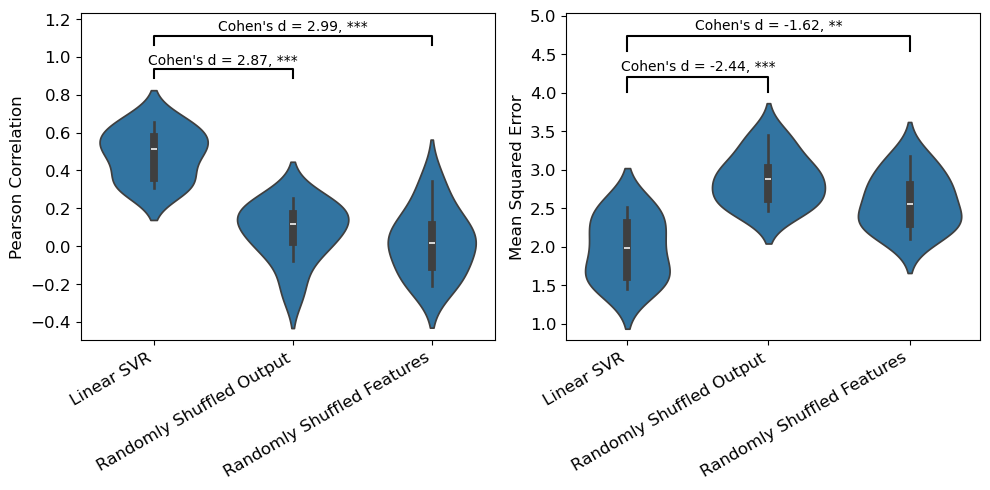

In [52]:
figB, axB = plt.subplots(ncols = 2, figsize = (10,5))

for i, (metric, viz_df) in enumerate(viz_dfs.items()):
    viz_df = pd.melt(viz_df, value_name=metric, var_name = 'Model Type')
    
    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric]: 'Linear SVR', 
                              'random_y_test_' +mmap[metric]: 'Randomly Shuffled Output', 
                             'random_X_test_' +mmap[metric]: 'Randomly Shuffled Features'})
    
    # get statistics
    res_stats, mod_combs = get_stats(viz_df, random = True, metric_type = metric)
    
    sns.violinplot(data = viz_df, x = 'Model Type', y = metric, ax = axB[i])
    
    
    xlabels = [x._text for x in axB[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, axB[i].get_xticks()))
    
    y_lower, y = axB[i].get_ylim()
    h = unit_map['h'][metric]
    
    
    axB[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'right')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric])
            axB[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric]
            axB[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        axB[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric])
    axB[i].set_xlabel('')
    
    axB[i].title.set_fontsize(axB[i].title.get_fontsize() + 2)
    axB[i].xaxis.label.set_fontsize(axB[i].xaxis.label.get_fontsize() + 2)
    axB[i].yaxis.label.set_fontsize(axB[i].yaxis.label.get_fontsize() + 2)
    for label in axB[i].get_xticklabels() + axB[i].get_yticklabels():
        label.set_fontsize(label.get_fontsize() + 2)

    
figB.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'random_transcriptomics.png'), 
            dpi=300, 
            bbox_inches="tight")  

/tmp/ipykernel_658494/3617146023.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i, j].set_xticklabels(xlabels,
/tmp/ipykernel_658494/3617146023.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i, j].set_xticklabels(xlabels,
/tmp/ipykernel_658494/3617146023.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i, j].set_xticklabels(xlabels,
/tmp/ipykernel_658494/3617146023.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i, j].set_xticklabels(xlabels,
/tmp/ipykernel_658494/3617146023.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i, j].set_x

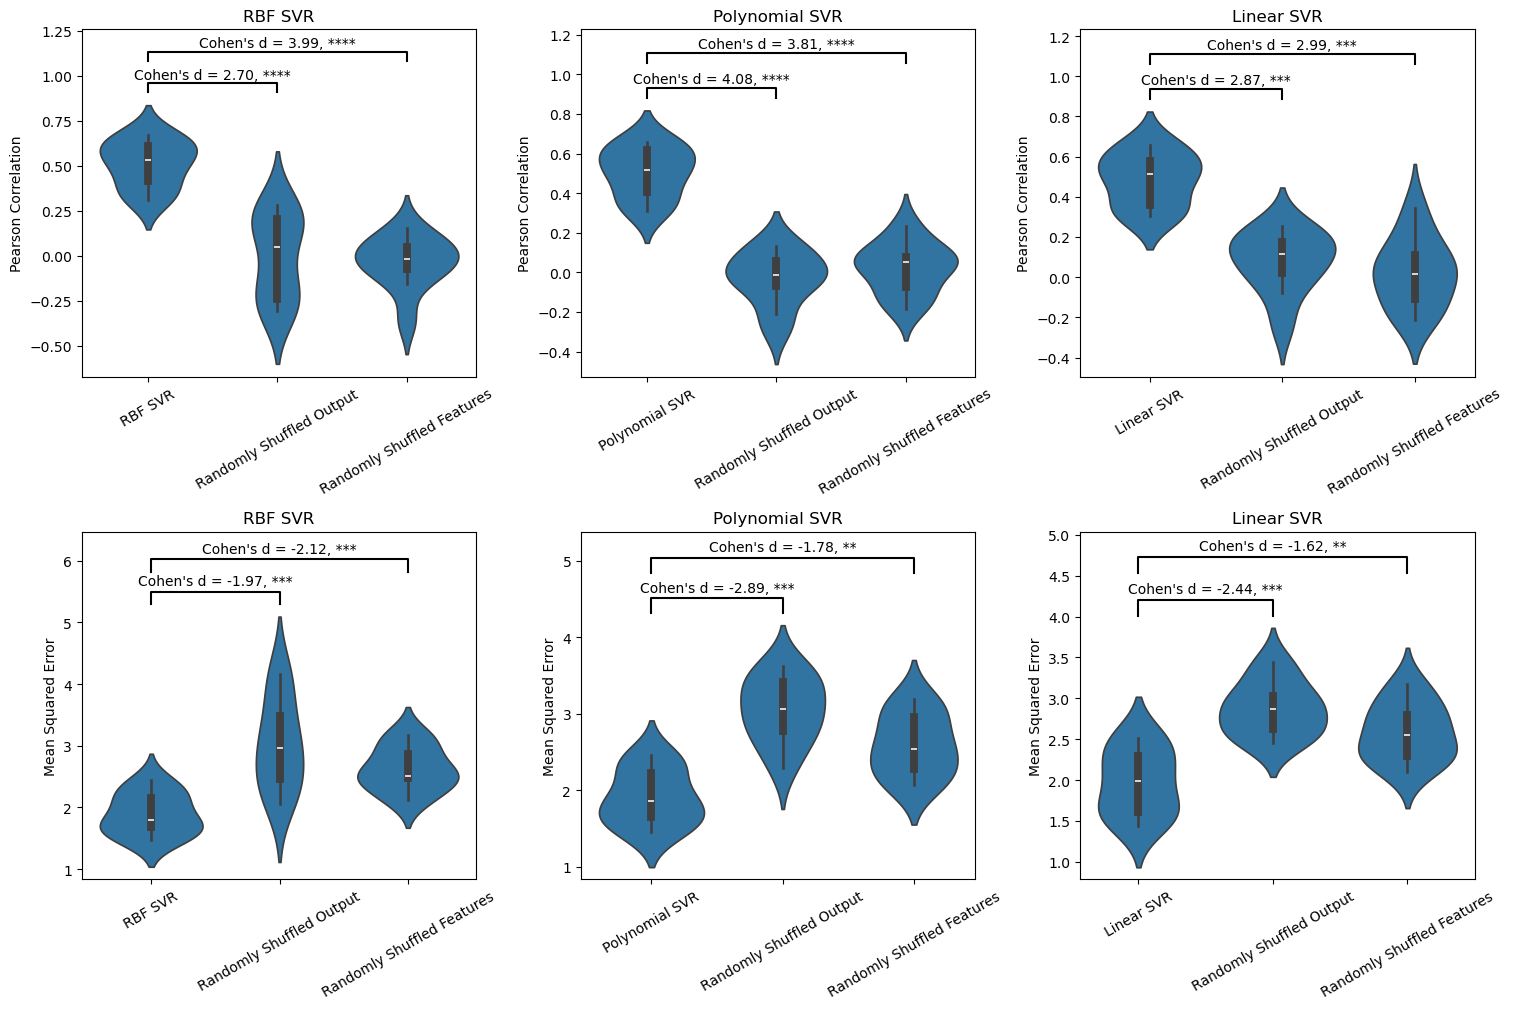

In [53]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
# split by metric type
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]

viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(['Pearson Correlation', 'Mean Squared Error'], ['corr', 'mse']))
model_map = dict(zip(['svr_rbf', 'svr_linear', 'svr_poly'], 
                    ['RBF SVR', 'Linear SVR', 'Polynomial SVR']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

def get_stats_all(viz_df, stat_type, model_type, metric_type):
    res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
    mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    
    if stat_type == 'random':
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1]
        
        if metric_type == 'Pearson Correlation':
            alternative = 'greater'
        elif metric_type == 'Mean Squared Error':
            alternative = 'less'
        
        # reorder
        shared_element = model_map[model_type]
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]
    elif stat_type == 'within':
        alternative = 'two-sided'
    elif stat_type == 'transcriptomics':     
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Transcriptomics') == 1]
        alternative = 'two-sided'
        
#         if metric_type == 'Pearson Correlation':
#             alternative = 'greater'
#         elif metric_type == 'Mean Squared Error':
#             alternative = 'less'
        
#         # reorder
#         shared_element = 'Linear SVR - Transcriptomics'
#         mod_combs = [
#             (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
#             for elem in mod_combs
#         ]
        

    for mc in mod_combs:
        a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
        b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

        pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
        cd = cohen_d(a,b)

        res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

    _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
    res_stats['fdr'] = fdr
    
    return res_stats, mod_combs


ncols = len(best_pipelines)
nrows = 2 # two metrics
fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols*5.1, nrows*5.1))

for j, model_type in enumerate(model_order):
#     break
    
    for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
        viz_df = viz_df_[[col for col in viz_df_ if model_type in col]]
        viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

        # some formatting
        viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type], 
                                  'random_y_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Output', 
                                 'random_X_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Features'})
        
        # may want to do this across all comparisons simultaneously
        res_stats, mod_combs = get_stats_all(viz_df, stat_type = 'random', model_type = model_type, metric_type = metric_type)

        sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i, j])
        ax[i, j].set_title(model_map[model_type])
        ax[i, j].set_xlabel('')
        
        xlabels = [x._text for x in ax[i, j].get_xticklabels()]
        ax[i, j].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
        
        x_pos = dict(zip(xlabels, ax[i,j].get_xticks()))

        y_lower, y = ax[i,j].get_ylim()
        h = unit_map['h'][metric_type]
        
        # significance
        sig_counter = 0
        for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
            x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

            fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
            cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

            significance = "N.S."
            if fdr <= 1e-4:
                significance = "****"
            elif fdr <= 0.001:
                significance = "***"
            elif fdr <= 0.01:
                significance = "**"
            elif fdr <= 0.1:
                significance = "*"

            if significance != 'N.S.':
    #             y_pos = y+(sig_counter*0.15)
                y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
                ax[i,j].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                        [y_pos, y_pos+h, y_pos+h, y_pos], 
                        lw=1.5, c='black')
                y_pos*=unit_map['y_pos_scale'][metric_type]
                ax[i,j].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                        ha='center', va='bottom', fontsize=10)
                sig_counter += 1
        if sig_counter != 0:
            ax[i,j].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'random_transcriptomics_all_consensus.png'), 
            dpi=300, 
            bbox_inches="tight")  



We can see that the Linear SVR outperforms random baselines for both Pearson correlation and MSE. 

Let's also ensure the consensus non-linear SVRs did not perform better than the linear SVRs:

In [54]:
# load in Nikos' NN assessments
nn_res = pd.read_csv(os.path.join(data_path, 'processed', 'transcriptomics_NN_performance_consensusfolds_pearson.csv'), 
                    index_col = 0)

# add mse
nn_res_mse = pd.read_csv(os.path.join(data_path, 'processed', 'transcriptomics_NN_performance_consensusfolds_mse.csv'), 
                    index_col = 0)
nn_res['single model mse'] = nn_res_mse[['single model MSE']]
nn_res['ensemble_mse'] = nn_res_mse[['ensemble_MSE']]



nn_res = nn_res[nn_res.set == 'test'].copy()

nn_res_single = nn_res[['single model r', 'single model mse', 'fold']].copy()


nn_res_ensemble = nn_res[['ensemble_r', 'ensemble_mse', 'fold']].copy()
nn_res_ensemble.drop_duplicates(keep = 'first', inplace = True)
nn_res_ensemble.reset_index(drop = True, inplace = True)

nn_res_single.columns = ['test_corr_single_NN', 'test_mse_single_NN', 'fold']
nn_res_ensemble.columns = ['test_corr_ensemble_NN', 'test_mse_ensemble_NN', 'fold']



In [55]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']].copy()
viz_df = viz_df[[col for col in viz_df if 'random' not in col]].copy()

viz_df.rename(columns = {'test_corr_svr_linear': 'test_corr', 
                        'test_mse_svr_linear': 'test_mse'}, inplace = True)
# add ensemble nn
viz_df = pd.merge(viz_df, nn_res_ensemble, how='inner', on='fold')

viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]].copy()
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]].copy()

viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(['Pearson Correlation', 'Mean Squared Error'], ['corr', 'mse']))

unit_map = {'h': dict(zip(['Pearson Correlation', 'Mean Squared Error'], [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

/tmp/ipykernel_2507153/1493972197.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axC[i].set_xticklabels(xlabels,
/tmp/ipykernel_2507153/1493972197.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axC[i].set_xticklabels(xlabels,


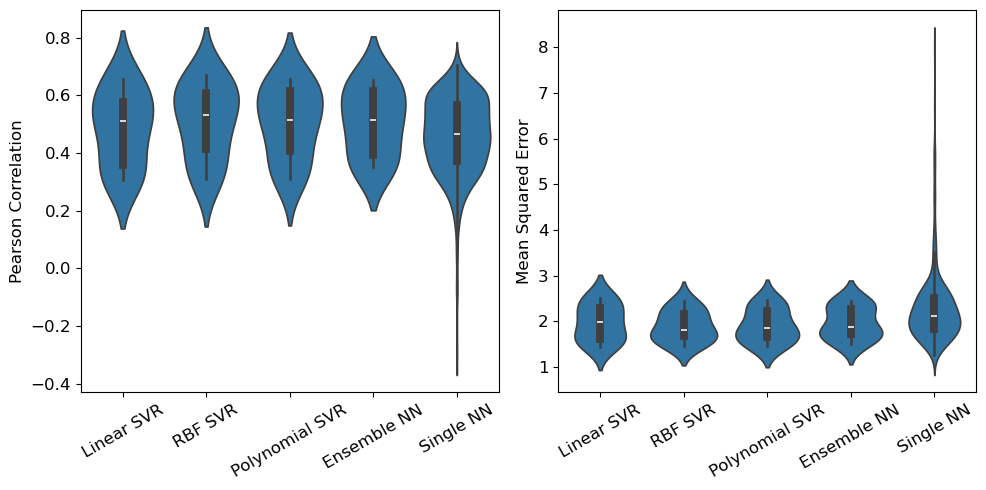

In [78]:
figC, axC = plt.subplots(ncols = 2, figsize = (10,5))

am = {'Pearson Correlation': False, 'Mean Squared Error': True}

for i, (metric, viz_df) in enumerate(viz_dfs.items()):
    viz_df = pd.melt(viz_df, value_name=metric, var_name = 'Model Type')
    
    # add the single NN
    nn_res_single_col = 'test_' + mmap[metric] + '_single_NN'
    nn_res_single_viz = pd.DataFrame(data = {'Model Type': [nn_res_single_col]*nn_res_single.shape[0], 
                         metric: nn_res_single[nn_res_single_col].tolist()
                        })
    viz_df = pd.concat([viz_df, nn_res_single_viz], axis = 0)
    
    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric]: 'Linear SVR', 
                              '_'.join(['test', mmap[metric], 'svr_rbf']): 'RBF SVR', 
                             '_'.join(['test', mmap[metric], 'svr_poly']): 'Polynomial SVR', 
                             '_'.join(['test', mmap[metric], 'ensemble_NN']): 'Ensemble NN',
                             '_'.join(['test', mmap[metric], 'single_NN']): 'Single NN'
                                                    })
#     rank_ordered_models = viz_df.groupby(['Model Type']).std()[metric].sort_values(ascending = True).index.tolist()
#     viz_df['Model Type'] = pd.Categorical(viz_df['Model Type'], 
#                                           categories = rank_ordered_models, 
#                                           ordered = True)

    
    
#     viz_df = viz_df[viz_df[metric].notna()]
    
    # get statistics
    res_stats, mod_combs = get_stats(viz_df, 
                                     random = False, 
                                     metric_type = None # always two-sided
                                    )
    if metric == 'Pearson Correlation':
        pearson_res_stats = res_stats
    
    sns.violinplot(data = viz_df, x = 'Model Type', y = metric,
                   ax = axC[i])
    
#     if metric == 'Mean Squared Error':
#         axC[i].set_yscale('log')
    
    
    xlabels = [x._text for x in axC[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, axC[i].get_xticks()))
    
    y_lower, y = axC[i].get_ylim()
    h = unit_map['h'][metric]
    
    
    axC[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric])
            axC[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric]
            axC[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        axC[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric])
    axC[i].set_xlabel('')
    
    axC[i].title.set_fontsize(axC[i].title.get_fontsize() + 2)
    axC[i].xaxis.label.set_fontsize(axC[i].xaxis.label.get_fontsize() + 2)
    axC[i].yaxis.label.set_fontsize(axC[i].yaxis.label.get_fontsize() + 2)
    for label in axC[i].get_xticklabels() + axC[i].get_yticklabels():
        label.set_fontsize(label.get_fontsize() + 2)

#     if i > 0: 
#         axC[i].ticklabel_format(axis='y', style='plain')
#         axC[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    
figC.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'consensus_transcriptomics.png'), 
            dpi=300, 
            bbox_inches="tight")  

There are no significant differences between the consensus models for SVR with any of the tested kernels.